In [5]:
%matplotlib inline

In [6]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
"""
This is a rough python implementation of the magnetometer compass calibration procedure outlined at:
http://mythopoeic.org/magnetometer/

The major difference is that I plan to implement a 4-point (N, E, S, W) calibration, instead of the 1-point+yaw rotation
procedure outlined in the link above.

The purpose of this code is for me to wrap my head around the algoritm before I implement it in Arduino/AvrC.

"""

#raw data from sensor
rawCalibrationMatrix = np.array([[311, 416, 279], #Nx, Ny, Nz
                                 [178, 330, 404], #Ex, Ey, Ez
                                 [-31, 377, 362], #Sx, Sy, Sz 
                                 [66, 501, 247]]) #Wx, Wy, Wz



#Subtract average the xyz-coordinates, in order to center points around origo
centered_calibrationVector = np.mean(rawCalibrationMatrix, axis=0) #columnvise mean
calibrationMatrix = rawCalibrationMatrix - centered_calibrationVector

#print(centered_calibrationVector)
#calibrationMatrix = calibrationMatrix.astype("int16")

pN = calibrationMatrix[0] #point North
pE = calibrationMatrix[1] #point East
pS = calibrationMatrix[2] #point South
pW = calibrationMatrix[3] #point West

#print(pN, pE, pS, pW)

def findPhi_z(pointVector):
    """
    Rotates a point around the Z-axis, so that its
    x-coordinate becomes 0 and y >= 0.
    Returns angle in radians
    """
    phi = -math.atan(-pointVector[0]/pointVector[1]) #n*pi-atan(-x/y)
    test_y = np.matmul(getZrotationMatrix(phi), pointVector)[1]
    if (test_y >= 0):
        return phi
    else:
        return phi+math.pi

def findPhi_x(pointVector):
    """
    Rotates a point around the X-axis, so that its z-coorinate becomes 0,
    and y > 0.
    """
    phi = -math.atan(-pointVector[2]/pointVector[1]) #n*pi-atan(-x/y)  
    test_y = np.matmul(getXrotationMatrix(phi), pointVector)[1]
    if (round(test_y) >= 0):
        return phi
    else:
        return phi+math.pi

def findPhi_y(pointVector):
    """
    Rotates a point around the Y-axis, so that its x-coordinate is negative,
    and z=0.
    """
    phi = -math.atan(-pointVector[2]/pointVector[0]) #n*pi-atan(-x/y)  
    test_x = pointVector[0]*math.cos(phi) + pointVector[2]*math.sin(phi)
    #test_x = np.matmul(getYrotationMatrix(phi), pointVector)[0]
    if (test_x <= 0):
        return phi
    else:
        return phi+math.pi
    
def getZrotationMatrix(phi):
    """
    Returns a matrix that rotates a point vector around the Z-axis phi radians
    """
    zRotatonMatrix = np.array([[math.cos(phi), -math.sin(phi), 0],
                                   [math.sin(phi), math.cos(phi), 0],
                                    [0, 0, 1]])
    return zRotatonMatrix
    
def getYrotationMatrix(phi):
    """
    Returns a matrix that rotates a point vector around the Y-axis phi radians
    """
    yRotatonMatrix = np.array([[math.cos(phi), 0,  math.sin(phi)],
                                   [0, 1, 0],
                                   [-math.sin(phi), 0, math.cos(phi)],
                                    ])
    return yRotatonMatrix
    
def getXrotationMatrix(phi):
    """
    Returns a matrix that rotates a point vector around the X-axis phi radians
    """
    xRotatonMatrix = np.array([[1, 0, 0],
                                [0, math.cos(phi), math.sin(phi)],
                                [0, -math.sin(phi), math.cos(phi)],
                                ])
    return xRotatonMatrix

def rotateMatrix(pointMatrix, rotationMatrix):
    """
    Rotates a matrix of points.
    Returns: pointmatrix rotated by the rotationmatrix
    """
    out = np.empty_like(pointMatrix)
    
    for i in range(out.shape[0]):
        out[i] = np.matmul(rotationMatrix, pointMatrix[i])
    
    return out
    
#print(np.around(calibrationMatrix))
phi_z = findPhi_z(pN)
pN_z = np.matmul(getZrotationMatrix(phi_z), pN)#.astype('int16')
#print(pN_z)
zRot = rotateMatrix(calibrationMatrix, getZrotationMatrix(phi_z))
#print(np.around(zRot))
phi_x = findPhi_x(pN_z)
pN_zx = np.matmul(getXrotationMatrix(phi_x), pN_z)#.astype('int16')
xRot = rotateMatrix(zRot, getXrotationMatrix(phi_x))
print(np.around(xRot))      
phi_y = findPhi_y(xRot[3])
yRot = rotateMatrix(xRot, getYrotationMatrix(phi_y))
print(np.around(yRot))
transformationMatrix = np.linalg.multi_dot([getYrotationMatrix(phi_y), getXrotationMatrix(phi_x), getZrotationMatrix(phi_z)])
print(transformationMatrix)
tst = np.matmul(transformationMatrix, pE)
print(np.around(tst))
heading = math.atan(tst[0]/tst[1]) #atan(x/y)
print(heading)

[[   0.  186.    0.]
 [  78.   22.   89.]
 [  20. -168.   -1.]
 [ -98.  -40.  -88.]]
[[   0.  186.   -0.]
 [ 118.   22.   14.]
 [  14. -168.  -14.]
 [-132.  -40.    0.]]
[[ 0.19910024 -0.73579509  0.64727481]
 [ 0.96998754  0.0538882  -0.23710807]
 [ 0.13958248  0.67505678  0.72444122]]
[ 118.   22.   14.]
1.38365965561


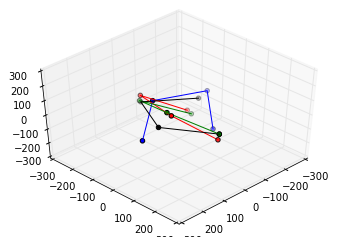

In [12]:
elevation, azim = 45, 45
minval, maxval = -300, 300
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(rawCalibrationMatrix[:,0], rawCalibrationMatrix[:,1], rawCalibrationMatrix[:,2], c='r')
#ax.plot(rawCalibrationMatrix[:,0], rawCalibrationMatrix[:,1], rawCalibrationMatrix[:,2], c='r')
ax.scatter(calibrationMatrix[:,0], calibrationMatrix[:,1], calibrationMatrix[:,2])
ax.plot(calibrationMatrix[:,0], calibrationMatrix[:,1], calibrationMatrix[:,2])
ax.scatter(zRot[:,0], zRot[:,1], zRot[:,2], c='r')
ax.plot(zRot[:,0], zRot[:,1], zRot[:,2], c='r')
ax.scatter(xRot[:,0], xRot[:,1], xRot[:,2], c='g')
ax.plot(xRot[:,0], xRot[:,1], xRot[:,2], c='g')
ax.scatter(yRot[:,0], yRot[:,1], yRot[:,2], c='black')
ax.plot(yRot[:,0], yRot[:,1], yRot[:,2], c='black')

ax.view_init(elev=elevation, azim=azim)
ax.set_xlim3d(minval, maxval)
ax.set_ylim3d(minval, maxval)
ax.set_zlim3d(minval, maxval)

fig.show()


### 